In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import warnings
from pathlib import Path
from glob import glob

import spikeinterface.full as si
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint

import UnitMatchPy.overlord as ov
import UnitMatchPy.metric_functions as mf

sys.path.append("/home/phornauer/Git/spikesorting/")
from spikesorting import unit_match as um


warnings.filterwarnings("ignore", category=RuntimeWarning)

si.set_global_job_kwargs(n_jobs=16, progress_bar=False)

In [3]:
parent_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/'
project_name = 'Torsten_2'
recording_date = '241030'
chip_id = 'T002523'
assay_name = 'Network'
assay_id = '*'
file_name = 'well001'

path_parts = [parent_path, project_name, recording_date, chip_id, assay_name, assay_id, file_name, "sorter_output","spike_times.npy"]
path_list = um.get_sorting_path_list(path_parts)

# Generate save path from the first sorting path
parts = Path(path_list[0]).parts
save_path = Path(os.path.join(*parts[:-3], "UM_data", parts[-2]))

param = {
    'spike_width': 30, # in samples
    'waveidx': np.arange(5,15), # index of the waveform to be used for the metric
    'peak_loc': 10, # index of the peak location in the waveform
    'no_shanks': 1, # unit_match parameter for neuropixel probe
    'shank_dist': 0, # unit_match parameter for neuropixel probe
    'save_path': save_path # path to save the unit_match data
}

Found 12 sorting paths matching the description:
/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/*/well001/sorter_output/spike_times.npy



In [4]:
waveforms, channel_pos = um.generate_templates(path_list)

Waveforms and channel positions loaded from /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well001


In [5]:
score_matrix, clus_info, param = um.get_score_matrix(waveforms, channel_pos, param, load_if_exists=True)

Score matrix loaded from /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well001/score_matrix.pkl


In [6]:
# We first match across sessions that are not affected by the KCl treatment
sel_idx = np.r_[0,3:12]

sel_matrix, sel_switch = um.select_sessions(score_matrix, clus_info['session_switch'], sel_idx)
unit_probs, unit_paths = um.match_across_session(sel_matrix, sel_switch, min_th = 0.8, n_misses = 0)

Threshold for matching units: 0.87, Number of matched units: 100


In [7]:
# Now we match across the KCl treatment sessions
kcl_idx = np.r_[0,1,2]
# But only for the units that were matched before
sel_units = unit_paths[:,0]
kcl_matrix, kcl_switch = um.select_sessions(score_matrix, clus_info['session_switch'], kcl_idx)
kcl_probs, kcl_paths = um.match_across_session(kcl_matrix, kcl_switch, min_th = 0.5, n_misses = 0, sel_units = sel_units)
# Check if only previously matched units were matched
assert(set(kcl_paths[:,0]).issubset(unit_paths[:,0]))

Threshold for matching units: 0.77, Number of matched units: 73


In [ ]:
full_paths = np.zeros((kcl_paths.shape[0], param['n_sessions']), dtype = int)
sel_paths = unit_paths - sel_switch[:-1] + clus_info['session_switch'][sel_idx]
for idx, u in enumerate(kcl_paths[:,0]):
    sel_path = sel_paths[sel_paths[:,0] == u,:][0]
    full_paths[idx,:] = np.concatenate((kcl_paths[idx,:], sel_path[1:]))
    
# Check if the sessions are in the correct order
assert(np.all(full_paths - clus_info['session_switch'][:-1] >= 0))

In [8]:
full_paths = np.zeros((unit_paths.shape[0], param['n_sessions']), dtype = int)
sel_paths = unit_paths - sel_switch[:-1] + clus_info['session_switch'][sel_idx]
for idx, u in enumerate(unit_paths[:,0]):
    sel_path = sel_paths[idx,:]
    if u in kcl_paths[:,0]:
        kcl_path = kcl_paths[kcl_paths[:,0] == u,:][0]
        full_paths[idx,:] = np.concatenate((kcl_path, sel_path[1:]))
    else:
        full_paths[idx,:] = np.concatenate(([u, -1, -1], sel_path[1:]))

In [ ]:
recordings, sortings = um.load_objects(path_list)
assert(len(sortings) ==  full_paths.shape[1])

In [29]:
sorting_ids = full_paths - clus_info['session_switch'][:-1]

In [42]:
np.argwhere(sorting_ids[:,0] >= 0).squeeze()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
sel_sortings = 

array([ 37,  57, 127,  83,  90,  40,  81,  41,  99,   6,   1, 124,  69,
        95, 125,  76,  48,  96,  60, 117,  43,  52,  38,  89,  55,  10,
        20,  42,  56,  54, 136,  16, 115, 126, 111,  31,  23, 135,  21,
        13,  47, 102, 120,  77,  73,  61, 104, 105,  15,   7,  74,  63,
       112, 137,  39,  80,  68,  86,  58,  36,  28,  49,  79,  92, 133,
       108,   8,  98,  17,   4,  85,  53,  70, 114,  66, 101,   3, 118,
       109,   9,  12,  44,  11,  51, 141,  33,  62,  30,   0,  94,  84,
        45, 110, 128,  82,  27,  65,  22,  64, 106])

In [ ]:
matched_sortings = []
for i, s in enumerate(sortings):
    sel_unit_ids = um.select_good_units(s).get_unit_ids()[sorting_ids[:,i]]
    new_unit_ids = np.argwhere(sorting_ids[:,i] >= 0).squeeze()
    sel_unit_ids = sel_unit_ids[new_unit_ids]
    matched_sortings.append(s.select_units(sel_unit_ids, renamed_unit_ids=new_unit_ids))
    new_sorting_folder = param["save_path"].joinpath(path_list[i].parts[-3])
    
    sorting_analyzer = si.create_sorting_analyzer(
        sorting=matched_sortings[i], 
        recording=recordings[i])
    
    sorting_analyzer.compute(['random_spikes', 'waveforms', 'templates'])

In [104]:
sorting_analyzer = si.create_sorting_analyzer(
    sorting=matched_sortings[2], 
    recording=recordings[2])


In [125]:
compute_dict = {
    'random_spikes': {'method': 'uniform', 'max_spikes_per_unit': 10000},
    'waveforms': {'ms_before': 1.0, 'ms_after': 2.0},
    'templates': {},
    "spike_amplitudes": {}
}
sorting_analyzer.compute(compute_dict)

In [109]:
si.export_to_phy(sorting_analyzer, 
                 output_folder=new_sorting_folder, 
                 copy_binary=False, 
                 compute_pc_features=False,
                 remove_if_exists=True)

Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well001/48h/params.py


In [144]:
sel_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/Washout/well001/sorter_output/'
times = np.load(sel_path + 'spike_times.npy')
amps = np.load(sel_path + 'amplitudes.npy')

In [126]:
temp = sorting_analyzer.get_extension("spike_amplitudes")
temp.get_data().shape

(37558,)

In [153]:
spikes._some_spikes.shape

(37558,)

In [131]:
wf = sorting_analyzer.get_extension("waveforms")
wfs = wf.get_data()

In [149]:
spikes = sorting_analyzer.get_extension("random_spikes")

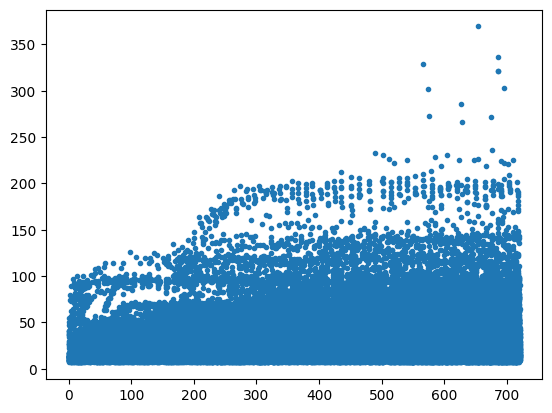

In [145]:
plt.plot(times/10000, amps,'.')

In [ ]:
param["save_path"].joinpath(path_list[i].parts[-3])

PosixPath('/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well001')

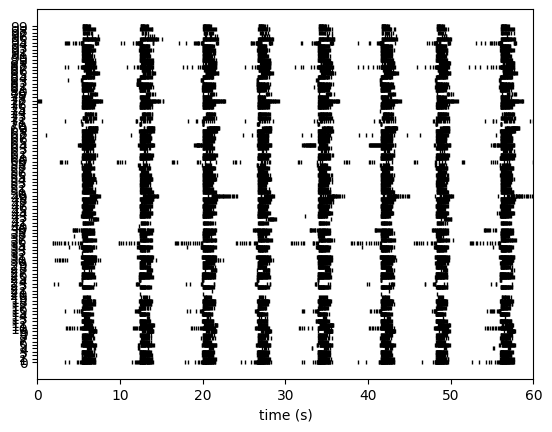

In [85]:
si.plot_rasters(matched_sortings[4],time_range = [0,60])

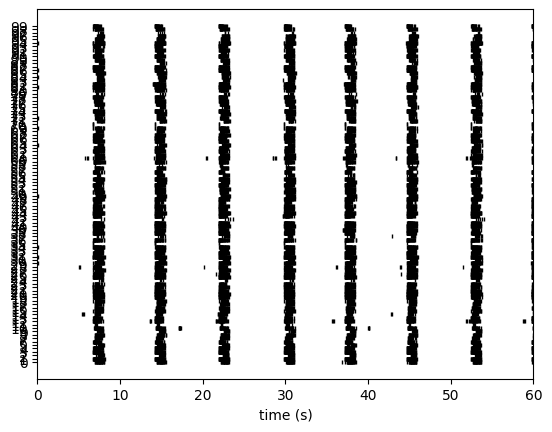

In [83]:
si.plot_rasters(matched_sortings[0],time_range = [0,60])

In [24]:
clus_info["session_switch"]

array([   0,  142,  341,  727, 1155, 1543, 1887, 2199, 2498, 2773, 3085,
       3378, 3652])

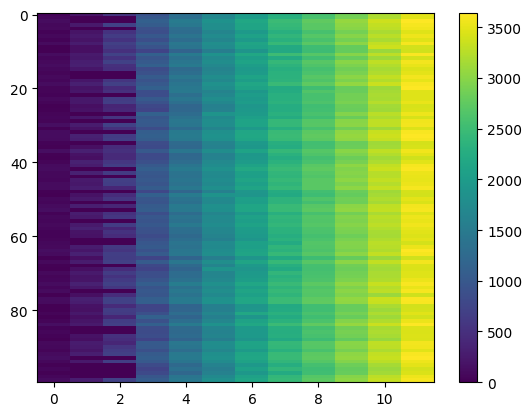

In [125]:
plt.imshow(full_paths, aspect='auto')
plt.colorbar()
plt.show()